# Route Optimization and Behavioral Analysis of Last-Mile Deliveries using Amazon Challenge Data

This project analyzes the 2021 Amazon Last Mile Routing Research Challenge dataset to explore and optimize last-mile delivery performance. We will:
- **Reconstruct and visualize delivery routes from planned and actual sequences**.
- **Analyze driver behavior by comparing planned vs. actual delivery sequences**.
- **Build a network graph of delivery stops using networkx or Neo4j**.
- **Propose optimized delivery sequences based on graph theory and ML models**.

The outcome is an interpretable, visual, and data-driven approach to urban logistics, suitable for graph analytics and route optimization research.

## Import from AWS S3 Bucket

In [2]:
# Download the dataset from the AWS S3 Bucket
# ==============================================================================
# !aws s3 sync --no-sign-request s3://amazon-last-mile-challenges/almrrc2021/ ./almrrc2021/

## Load necessary library packages

In [3]:
# Data manipulation
# ==============================================================================
import json
import os
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

# Data visualisation
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import MarkerCluster

# Graph and Network Analysis
# ==============================================================================
import geopandas as gpd
import osmnx as ox
import networkx as nx

# Optimisation libraries
# ==============================================================================
import pulp 

# Date/Time handling
# ==============================================================================
import datetime

# Machine Learning modelling
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## 1. Reconstruct and visualize delivery routes from planned and actual sequences

In this section, we will: 

- Load the dataset
- Parse planned and actual routes
- Merge them with lat/lng/location info
- Build a clean DataFrame with visit order and location (actual delivery path)

In [8]:
from pprint import pprint

# Load planned routes
# ==============================================================================
with open("./almrrc2021/almrrc2021-data-evaluation/model_apply_inputs/eval_route_data.json", 'r') as f:
    route_data = json.load(f)

# Load actual sequences
# ==============================================================================
with open("./almrrc2021/almrrc2021-data-evaluation/model_score_inputs/eval_actual_sequences.json", 'r') as f:
    actual_data = json.load(f)

# Inspect top-level structure
print("Type of route_data:", type(route_data))
print("Type of actual_data:", type(actual_data))

print(f"---------------------------")

print("Sample route_id in route_data:", list(route_data.keys())[:3])
print("Sample route_id in actual_data:", list(actual_data.keys())[:3])

print(f"---------------------------")

# View contents for one route
sample_route_id = list(route_data.keys())[0]

print(f"---------------------------")

print("Keys in planned route entry:")
pprint(route_data[sample_route_id].keys())

print(f"---------------------------")

print("Planned Route Sample (shortened):")
pprint(route_data[sample_route_id])

Type of route_data: <class 'dict'>
Type of actual_data: <class 'dict'>
---------------------------
Sample route_id in route_data: ['RouteID_00092558-dece-4fb7-8d0d-7d0df3a4864e', 'RouteID_00337a3a-19c6-4821-9350-ad3cf0532047', 'RouteID_0034b931-97a7-485f-a6b3-b22798489094']
Sample route_id in actual_data: ['RouteID_00092558-dece-4fb7-8d0d-7d0df3a4864e', 'RouteID_00337a3a-19c6-4821-9350-ad3cf0532047', 'RouteID_0034b931-97a7-485f-a6b3-b22798489094']
---------------------------
---------------------------
Keys in planned route entry:
dict_keys(['station_code', 'date_YYYY_MM_DD', 'departure_time_utc', 'executor_capacity_cm3', 'stops'])
---------------------------
Planned Route Sample (shortened):
{'date_YYYY_MM_DD': '2018-06-17',
 'departure_time_utc': '17:23:00',
 'executor_capacity_cm3': 3539605.75,
 'station_code': 'DLA8',
 'stops': {'AH': {'lat': 33.88548,
                  'lng': -118.344553,
                  'type': 'Dropoff',
                  'zone_id': 'K-21.3E'},
           'AJ'

In [10]:
# Convert One Route into a DataFrame
# ==============================================================================
# Pick a sample route_id
sample_id = list(route_data.keys())[0]
stops_dict = route_data[sample_id]["stops"]

# Convert to DataFrame
# ==============================================================================
stops_df = pd.DataFrame.from_dict(stops_dict, orient='index').reset_index()
stops_df = stops_df.rename(columns={"index": "stop_id"})

# Add metadata
# ==============================================================================
stops_df["route_id"] = sample_id
stops_df["station_code"] = route_data[sample_id]["station_code"]
stops_df["departure_time"] = route_data[sample_id]["departure_time_utc"]

# Display df
# ==============================================================================
display(stops_df.shape)
display(stops_df.dtypes)
display(stops_df.head())

(166, 8)

stop_id            object
lat               float64
lng               float64
type               object
zone_id            object
route_id           object
station_code       object
departure_time     object
dtype: object

stop_id        lat         lng     type  zone_id  \
0      AH  33.885480 -118.344553  Dropoff  K-21.3E   
1      AJ  33.902808 -118.355223  Dropoff  K-21.3A   
2      AL  33.893616 -118.358108  Dropoff  K-21.3B   
3      AN  33.891376 -118.350248  Dropoff  K-21.1G   
4      AP  33.880117 -118.344510  Dropoff  K-21.2D   

                                       route_id station_code departure_time  
0  RouteID_00092558-dece-4fb7-8d0d-7d0df3a4864e         DLA8       17:23:00  
1  RouteID_00092558-dece-4fb7-8d0d-7d0df3a4864e         DLA8       17:23:00  
2  RouteID_00092558-dece-4fb7-8d0d-7d0df3a4864e         DLA8       17:23:00  
3  RouteID_00092558-dece-4fb7-8d0d-7d0df3a4864e         DLA8       17:23:00  
4  RouteID_00092558-dece-4fb7-8d0d-7d0df3a4864e         DLA8       17:23:00

In [16]:
# Extract and sort the stop_ids by visit order
# ==============================================================================
actual_dict = actual_data[sample_id]["actual"]
actual_sequence_sorted = sorted(actual_dict.items(), key=lambda x: x[1])  # sort by visit order

# Create DataFrame
sequence_df = pd.DataFrame(actual_sequence_sorted, columns=["stop_id", "visit_order"])

# Merge with planned stop info
# ==============================================================================
merged_df = pd.merge(sequence_df, stops_df, on="stop_id", how="left")

# Display actual route (with location info)
# ==============================================================================
display(merged_df[["visit_order", "stop_id", "lat", "lng", "zone_id"]].head(10))

visit_order stop_id        lat         lng  zone_id
0            0      UZ  33.918699 -118.324843      NaN
1            1      YM  33.892955 -118.346119  K-21.3G
2            2      VO  33.891739 -118.346113  K-21.3G
3            3      YR  33.891527 -118.347504  K-21.3G
4            4      DT  33.891909 -118.347504  K-21.3G
5            5      DQ  33.891864 -118.347506  K-21.3G
6            6      QT  33.892877 -118.347505  K-21.3G
7            7      BO  33.893218 -118.347508  K-21.3G
8            8      TM  33.894205 -118.348315  K-21.3G
9            9      IV  33.893044 -118.348888  K-21.2G

## 2. Behaviour Analysis
### Analyze driver behavior by comparing planned vs. actual delivery sequences.

In this section, **we aim to quantify how much the driver deviated from the planned delivery sequence**.

By comparing the planned order of stops with the actual order, we can detect:
- Stops that were skipped or missed
- Stops that were visited out of order
- The average and maximum deviation from the original plan

This helps us answer:

***Did the driver follow the optimal plan? Or did they make changes — and if so, how significant were they?***

In [19]:
# Extract planned sequence from route_data
# ==============================================================================
planned_sequence = list(route_data[sample_id]["stops"].keys())

# Create DataFrame with planned order
# ==============================================================================
planned_df = pd.DataFrame({
    "stop_id": planned_sequence,
    "planned_order": range(1, len(planned_sequence) + 1)
})

# Merge the two DataFrames
# ==============================================================================
comparison_df = pd.merge(planned_df, sequence_df, on="stop_id", how="outer")

# Calculate deviation
# ==============================================================================
comparison_df["order_deviation"] = comparison_df["visit_order"] - comparison_df["planned_order"]

# Preview result
# ==============================================================================
display(comparison_df.sort_values("planned_order").head(10))

stop_id  planned_order  visit_order  order_deviation
0      AH              1           43               42
1      AJ              2          126              124
2      AL              3          100               97
3      AN              4           21               17
4      AP              5           59               54
5      AS              6           72               66
6      AY              7           41               34
7      BA              8           60               52
8      BB              9          139              130
9      BO             10            7               -3

In [21]:
# Visualise the deviation
# ==============================================================================
fig = px.bar(
    comparison_df.dropna(subset=["order_deviation"]), 
    x="stop_id", 
    y="order_deviation", 
    title="Deviation Between Planned and Actual Delivery Order",
    labels={"order_deviation": "Visit Deviation (Actual - Planned)"}
)
fig.show()

The driver deviated significantly from the planned sequence, with some stops delayed by over 100 positions and others advanced by 50+. This suggests that the ***actual delivery route was heavily rearranged***, either due to traffic, manual optimization, or changing delivery priorities.

## 3. Network Analysis
### Build a network graph of delivery stops using networkx or Neo4j

In this section, we will model the delivery route as a network graph using either networkx (Python) or Neo4j (graph database). Each delivery stop will become a node, and each transition from one stop to the next in the actual route will be a directed edge.

The graph structure allows us to:
- Visualize the full route as a connected path
- Analyze connectivity and flow between stops
- Prepare for graph-based algorithms like shortest path, centrality, or route optimization

Ultimately, this lays the foundation for deeper insight into route structure, inefficiencies, and future optimization strategies.

In [22]:
# Prepare data for export (nodes.csv: contains all delivery stops)
# ==============================================================================
nodes = merged_df[['stop_id', 'lat', 'lng']].drop_duplicates()
nodes.to_csv('nodes.csv', index=False)

# Prepare data for export (edges.csv (based on actual sequence))
# ==============================================================================
edges = merged_df[["stop_id"]].reset_index()
edges["to_stop"] = edges["stop_id"].shift(-1)
edges = edges.dropna()
edges = edges.rename(columns={"stop_id": "from_stop"})
edges.to_csv("edges.csv", index=False)

In [23]:
!pip install neo4j pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 4.3 MB/s eta 0:00:00a 0:00:01


In [64]:
from neo4j import GraphDatabase

# Replace with your actual connection details
# ==============================================================================
uri = "XXXXXXXXXXXX"
user = "XXXXXXXXXXXX"
password = "XXXXXXXXXXXX"

driver = GraphDatabase.driver(uri, auth=(user, password))

In [65]:
# Query the graph into Pandas
# ==============================================================================
def fetch_edges(tx):
    query = """
    MATCH (a:Stop)-[r:DELIVERS_TO]->(b:Stop)
    RETURN a.stop_id AS from_stop, b.stop_id AS to_stop
    """
    result = tx.run(query)
    return pd.DataFrame([row.data() for row in result])

with driver.session() as session:
    edges_df = session.read_transaction(fetch_edges)

print(edges_df.head())

# Fetch the nodes
# ==============================================================================
def fetch_nodes(tx):
    query = """
    MATCH (s:Stop)
    RETURN s.stop_id AS stop_id
    """
    result = tx.run(query)
    return pd.DataFrame([row.data() for row in result])

with driver.session() as session:
    nodes_df = session.read_transaction(fetch_nodes)

  from_stop to_stop
0        UZ      YM
1        YM      VO
2        VO      YR
3        YR      DT
4        DT      DQ


/var/folders/p4/km2q7qsd1cl5b1h60220jf8w0000gn/T/ipykernel_63845/1973686277.py:12: DeprecationWarning:

read_transaction has been renamed to execute_read

/var/folders/p4/km2q7qsd1cl5b1h60220jf8w0000gn/T/ipykernel_63845/1973686277.py:27: DeprecationWarning:

read_transaction has been renamed to execute_read



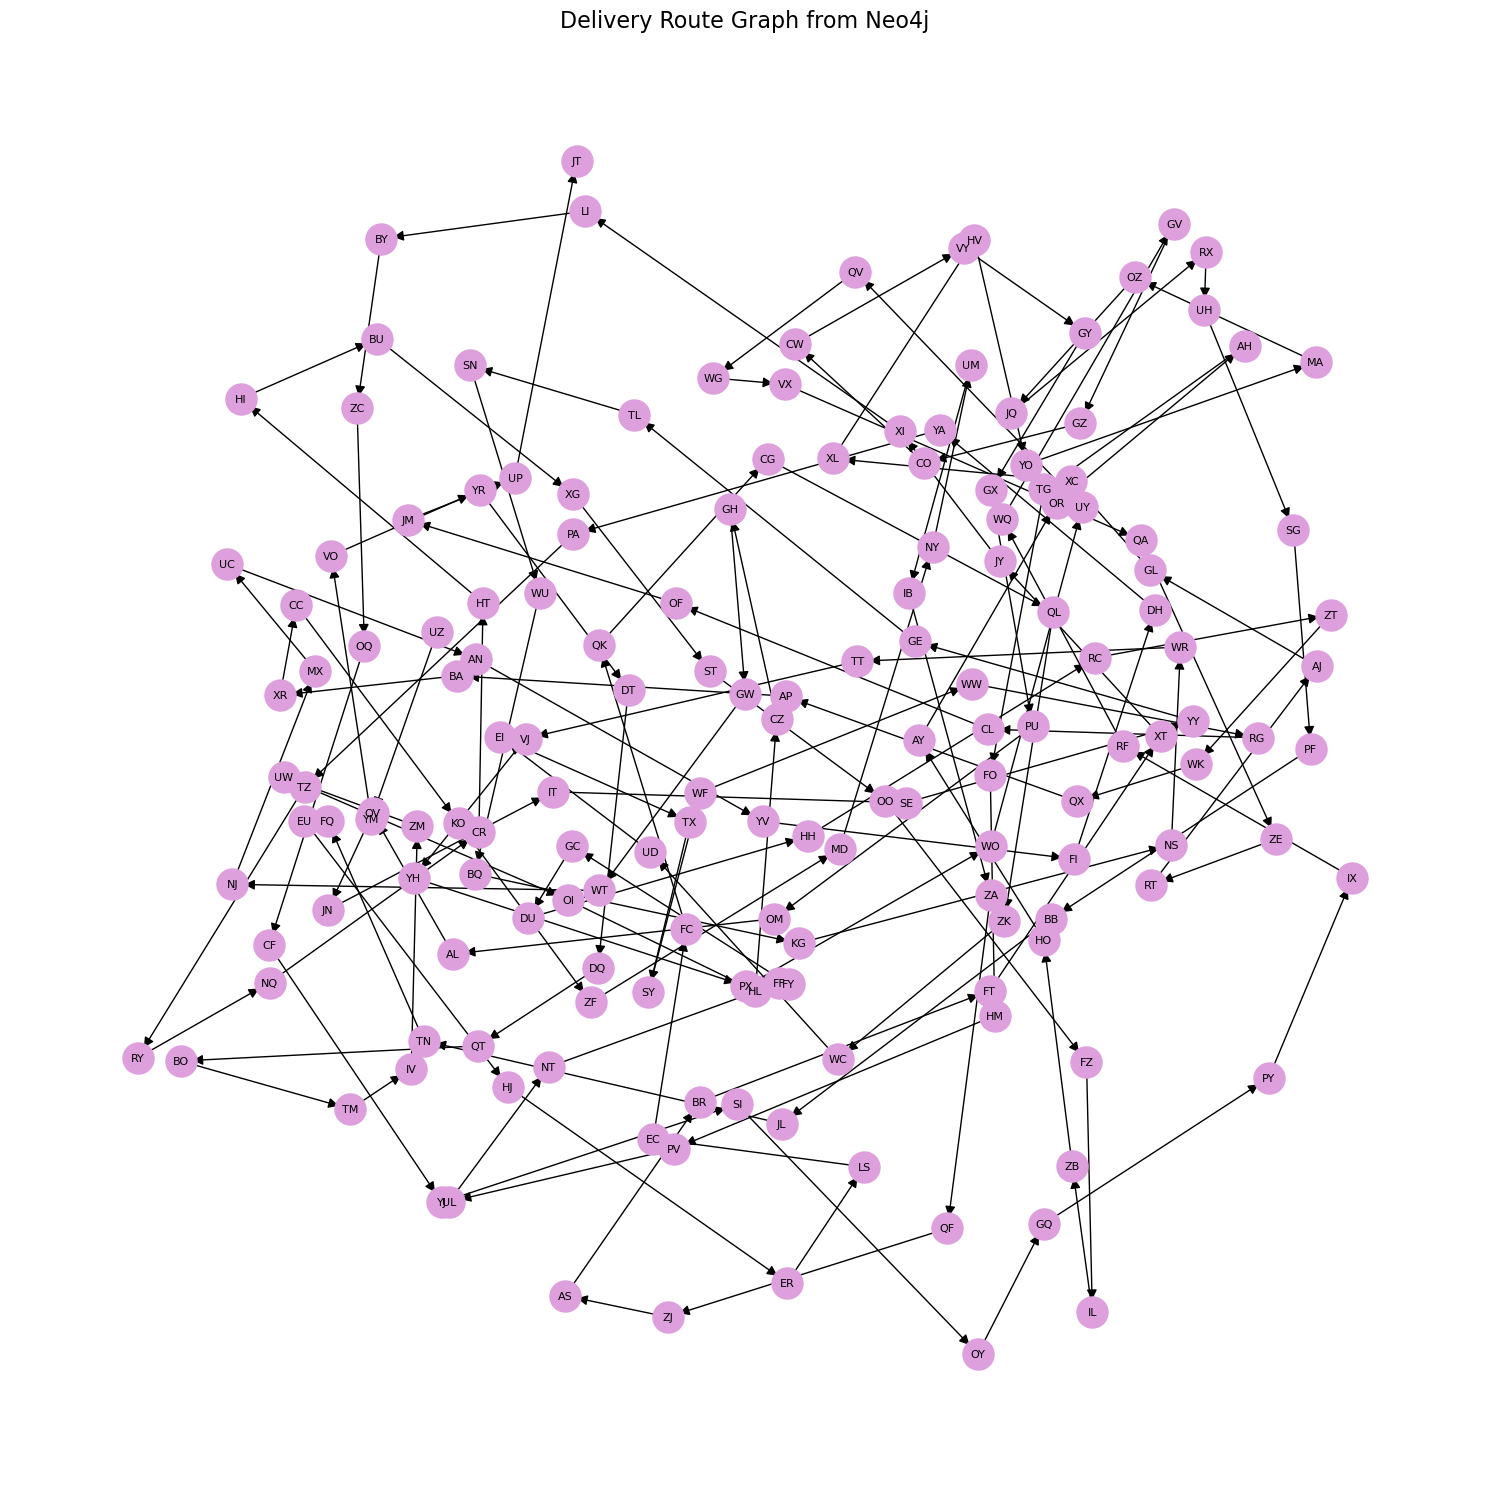

In [66]:
G = nx.DiGraph()
for _, row in edges_df.iterrows():
    G.add_edge(row['from_stop'], row['to_stop'])

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='plum')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, arrowsize=15)

plt.title("Delivery Route Graph from Neo4j", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

#### **Graph from Neo4j's Browser**

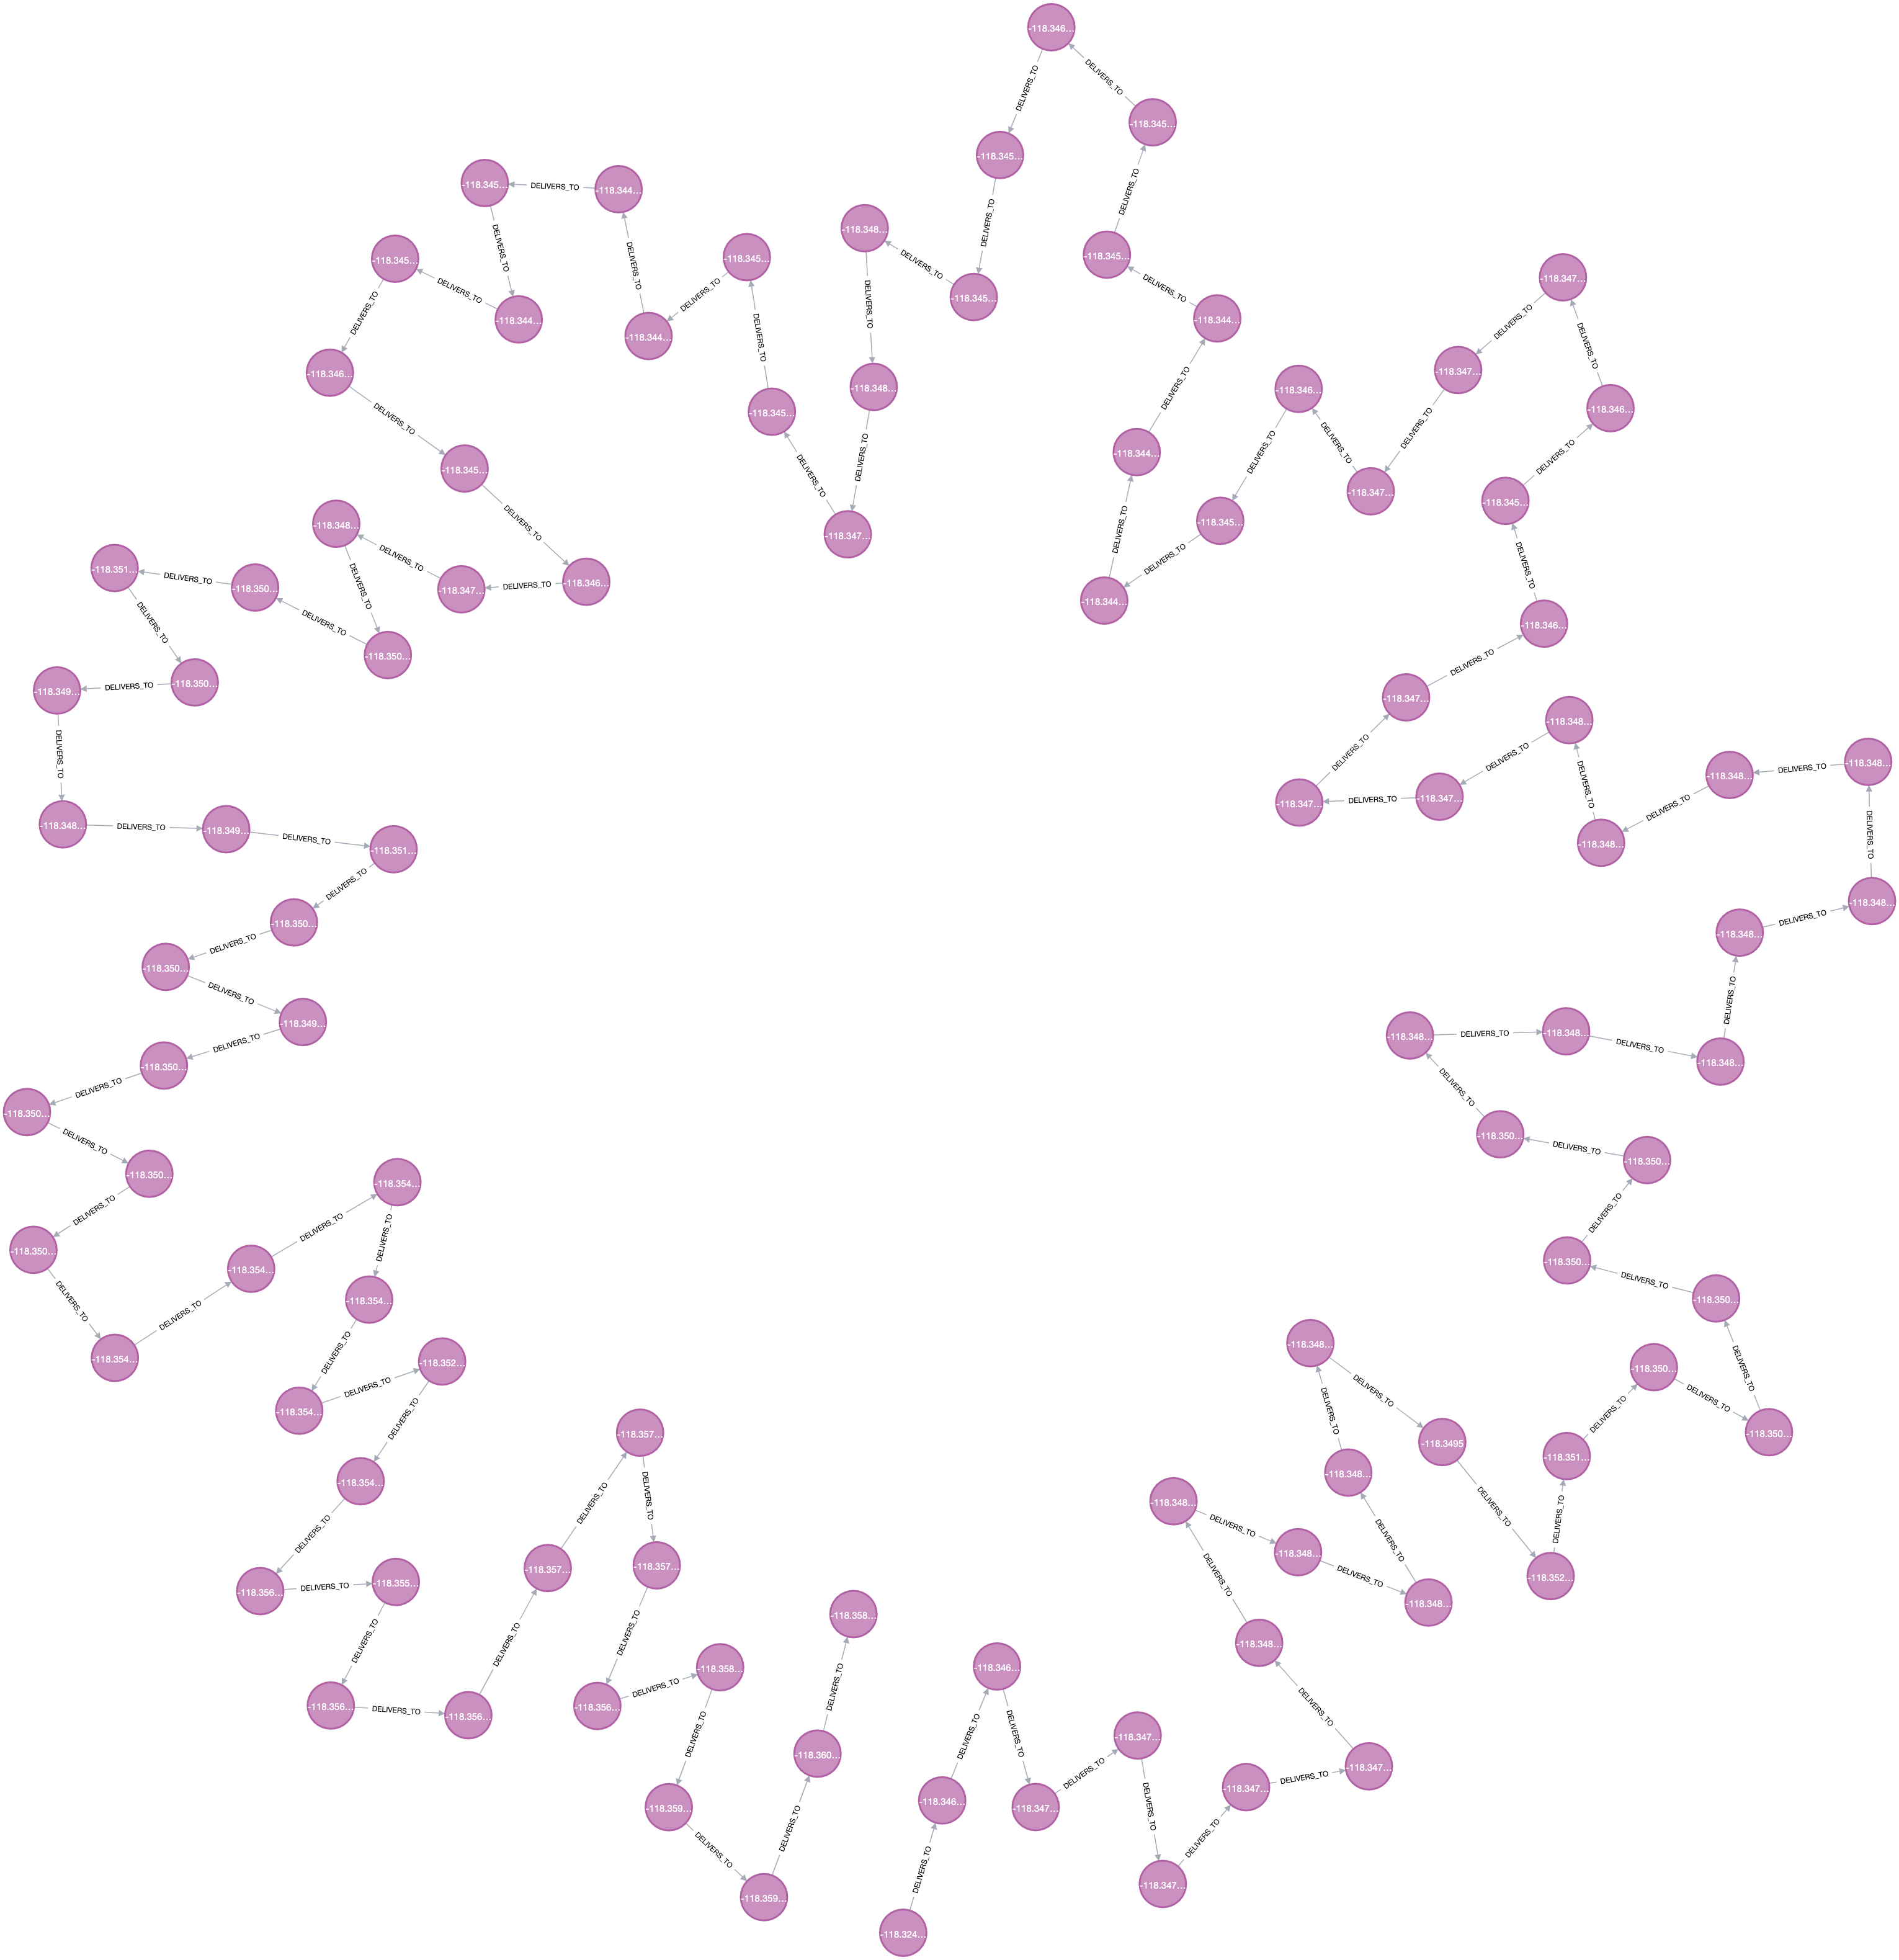

***We have now successfully constructed and visualized the delivery network as a directed graph***, enabling us to analyze connectivity and prepare for optimization tasks in the next section.

## 4. Route Optimization
### Propose optimized delivery sequences based on graph theory and ML models.

In this section, we focus on optimizing delivery sequences using both graph-theoretic algorithms and machine learning insights. By leveraging the network graph previously constructed, **we aim to identify shorter, more efficient routes and reduce travel time or distance**. This involves analyzing the structure of the graph, computing shortest paths, and exploring optimization techniques such as Dijkstra’s algorithm and centrality-based rerouting. 

Ultimately, **the goal is to improve route planning strategies for last-mile delivery performance**.

In [67]:
# Compute the shortest path from a selected origin node
# ==============================================================================
shortest_paths = nx.single_source_dijkstra_path(G, source='UZ')

# Visualise one path
# ==============================================================================
print(f"Path from UZ to HL: ", shortest_paths['HL'])

Path from UZ to HL:  ['UZ', 'YM', 'VO', 'YR', 'DT', 'DQ', 'QT', 'BO', 'TM', 'IV', 'ZM', 'UW', 'OI', 'HL']


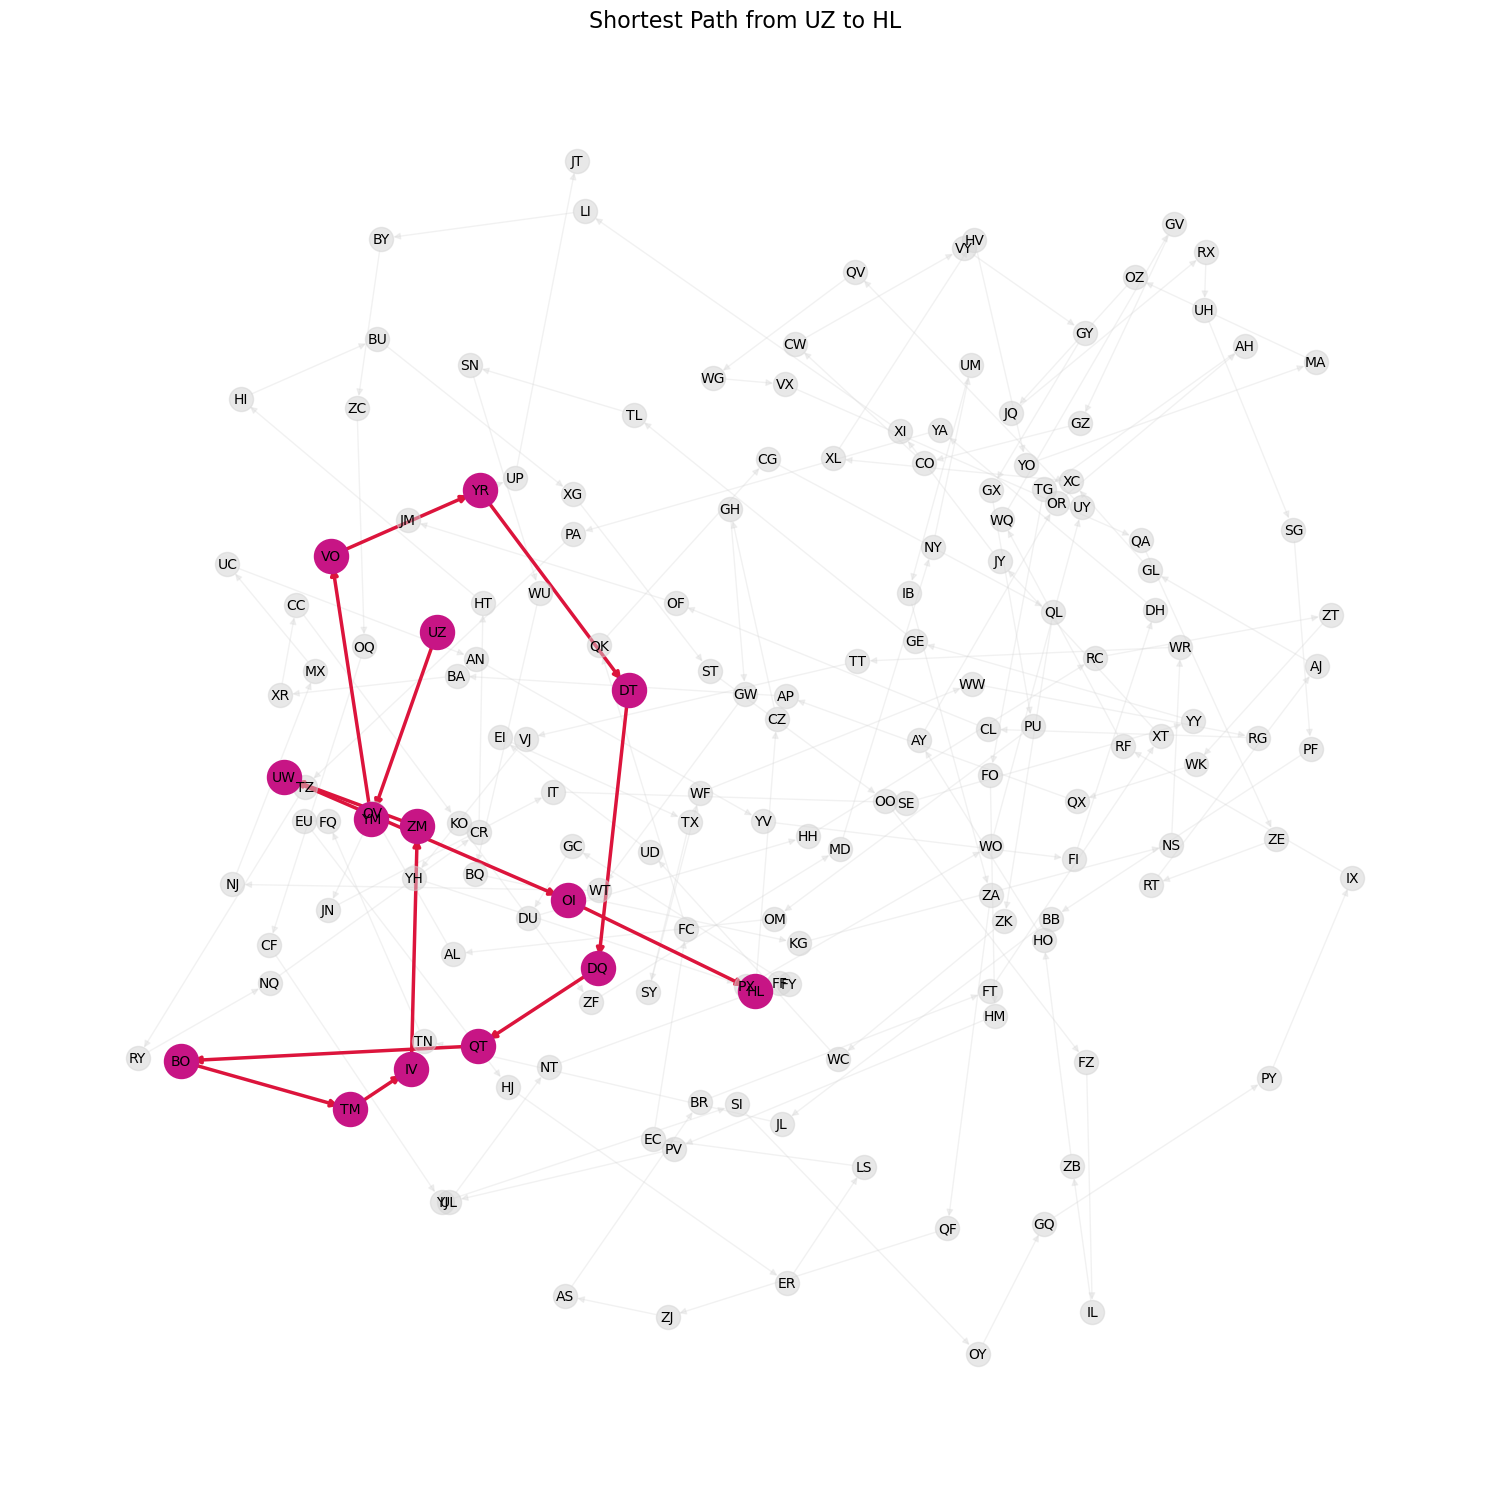

In [68]:
# Shortest path from a selected origin node
# ==============================================================================
shortest_path_nodes = shortest_paths['HL']
shortest_path_edges = list(zip(shortest_path_nodes, shortest_path_nodes[1:]))

# Reuse spring layout for consistency with previous plots
# ==============================================================================
pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)

plt.figure(figsize=(15, 15))

# Draw all nodes and edges with low opacity
# ==============================================================================
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightgrey', alpha=0.5)
nx.draw_networkx_edges(G, pos, edge_color='lightgrey', arrows=True, alpha=0.3)

# Highlight the shortest path nodes and edges
# ==============================================================================
nx.draw_networkx_nodes(G, pos, nodelist=shortest_path_nodes, node_size=600, node_color='mediumvioletred')
nx.draw_networkx_edges(G, pos, edgelist=shortest_path_edges, edge_color='crimson', width=2.5, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

plt.title("Shortest Path from UZ to HL", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

In [69]:
# Analyze centrality and reroute
# ==============================================================================
# Degree centrality
centrality = nx.degree_centrality(G)
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
print("Top central stops:", sorted_centrality[:5])

Top central stops: [('YM', 0.012121212121212121), ('VO', 0.012121212121212121), ('YR', 0.012121212121212121), ('DT', 0.012121212121212121), ('DQ', 0.012121212121212121)]


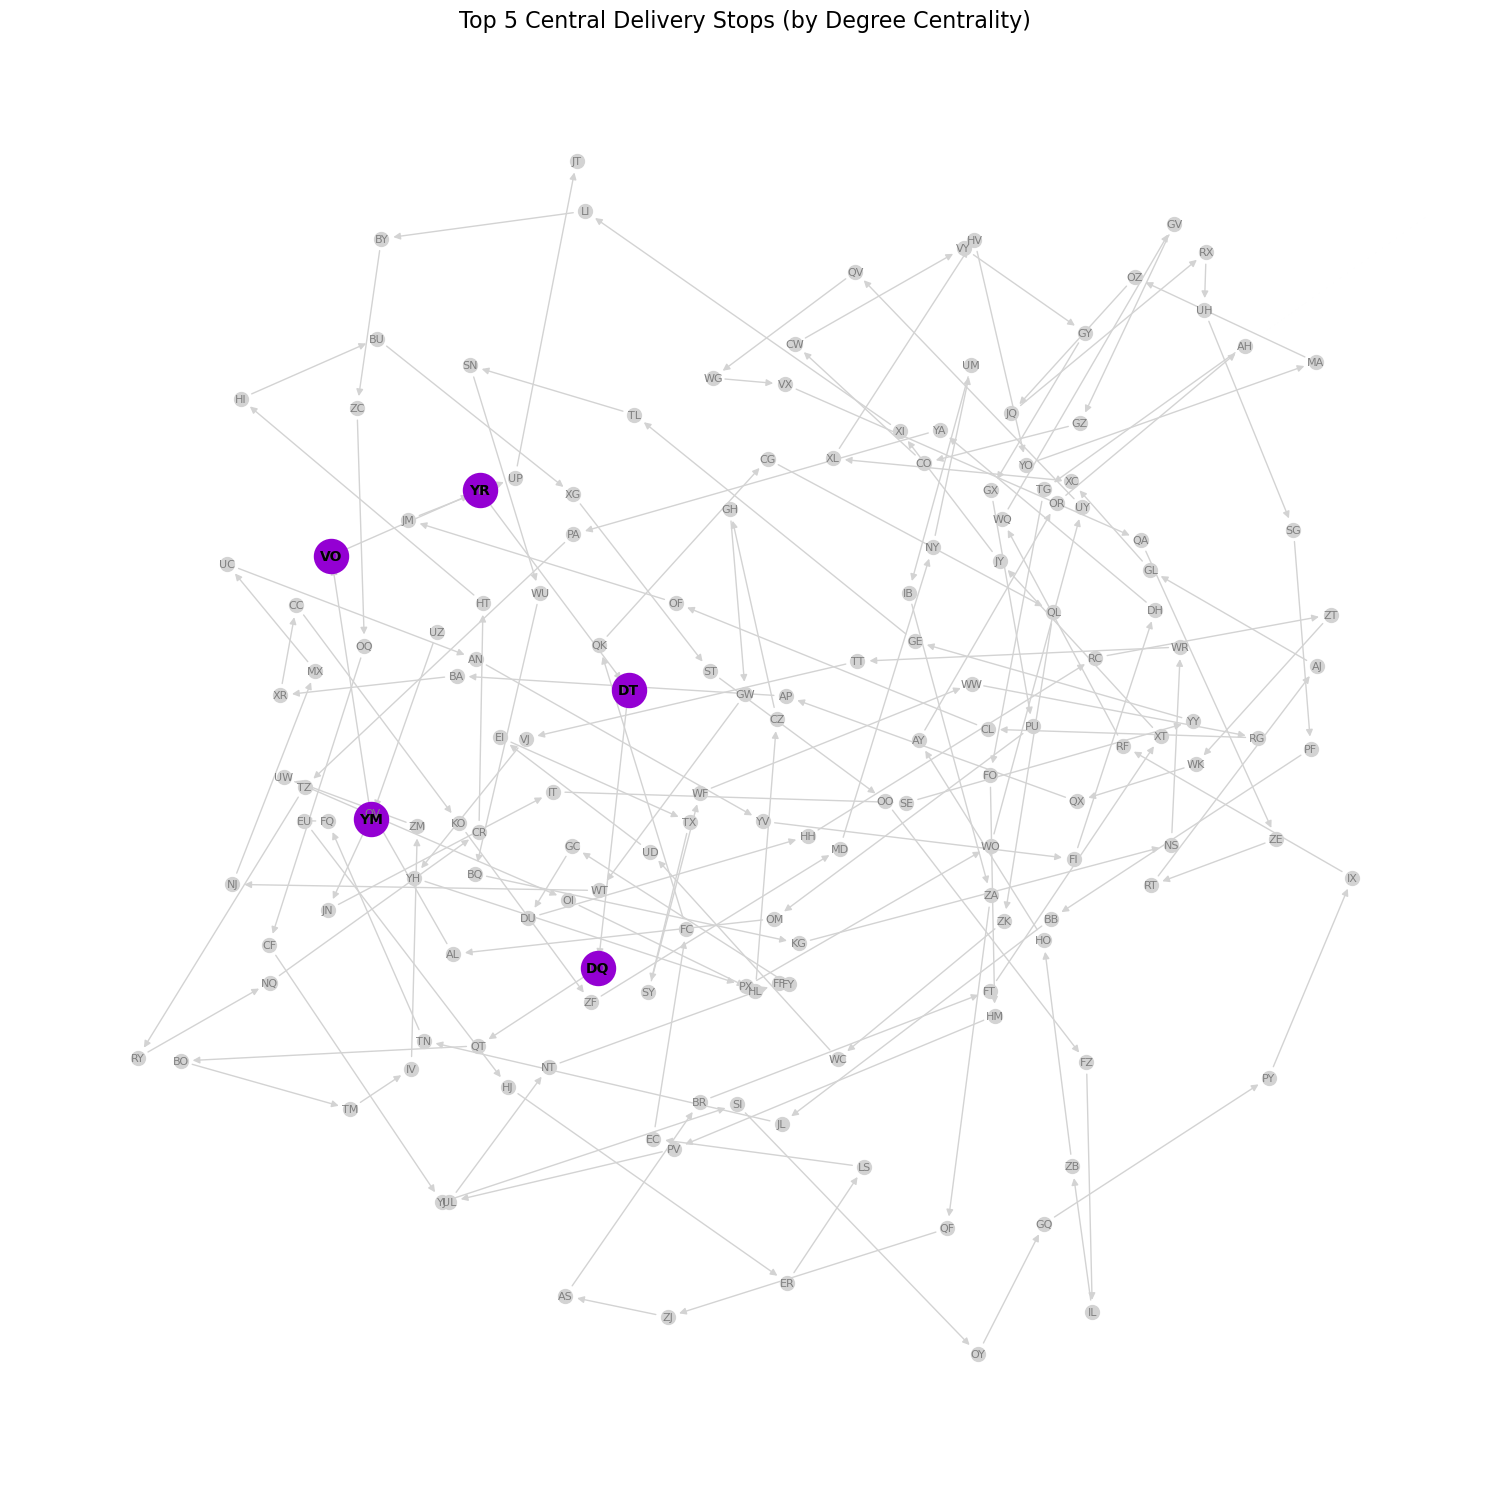

In [70]:
# Extract top 5 central nodes
# ==============================================================================
top_nodes = [node for node, _ in sorted_centrality[:5]]

plt.figure(figsize=(15, 15))

# Draw the entire graph faintly
# ==============================================================================
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightgray')
nx.draw_networkx_edges(G, pos, edge_color='lightgray')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='gray')

# Highlight top central nodes
# ==============================================================================
nx.draw_networkx_nodes(G, pos,
                       nodelist=top_nodes,
                       node_color='darkviolet',
                       node_size=600)

# Add labels for top nodes
# ==============================================================================
nx.draw_networkx_labels(G, pos,
                        labels={node: node for node in top_nodes},
                        font_size=10,
                        font_color='black',
                        font_weight='bold')

plt.title("Top 5 Central Delivery Stops (by Degree Centrality)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

In [71]:
# Print top 10 central nodes
# ==============================================================================
top_10 = sorted_centrality[:10]
print("Top 10 central stops by degree centrality:")
for node, score in top_10:
    print(f"{node}: {score:.4f}")

Top 10 central stops by degree centrality:
YM: 0.0121
VO: 0.0121
YR: 0.0121
DT: 0.0121
DQ: 0.0121
QT: 0.0121
BO: 0.0121
TM: 0.0121
IV: 0.0121
ZM: 0.0121


In [74]:
# Convert to Undirected Graph for TSP (TSP assumes a fully connected, undirected tour)
# ==============================================================================
G_undirected = G.to_undirected()

from networkx.algorithms.approximation import traveling_salesman_problem, greedy_tsp

tsp_subgraph = G_undirected.subgraph(tsp_nodes)

tsp_path = traveling_salesman_problem(tsp_subgraph, cycle=True, method=greedy_tsp)
print("TSP Route (undirected):", tsp_path)

TSP Route (undirected): ['YR', 'DT', 'DQ', 'QT', 'BO', 'TM', 'IV', 'ZM', 'IV', 'TM', 'BO', 'QT', 'DQ', 'DT', 'YR', 'VO', 'YM', 'VO', 'YR']


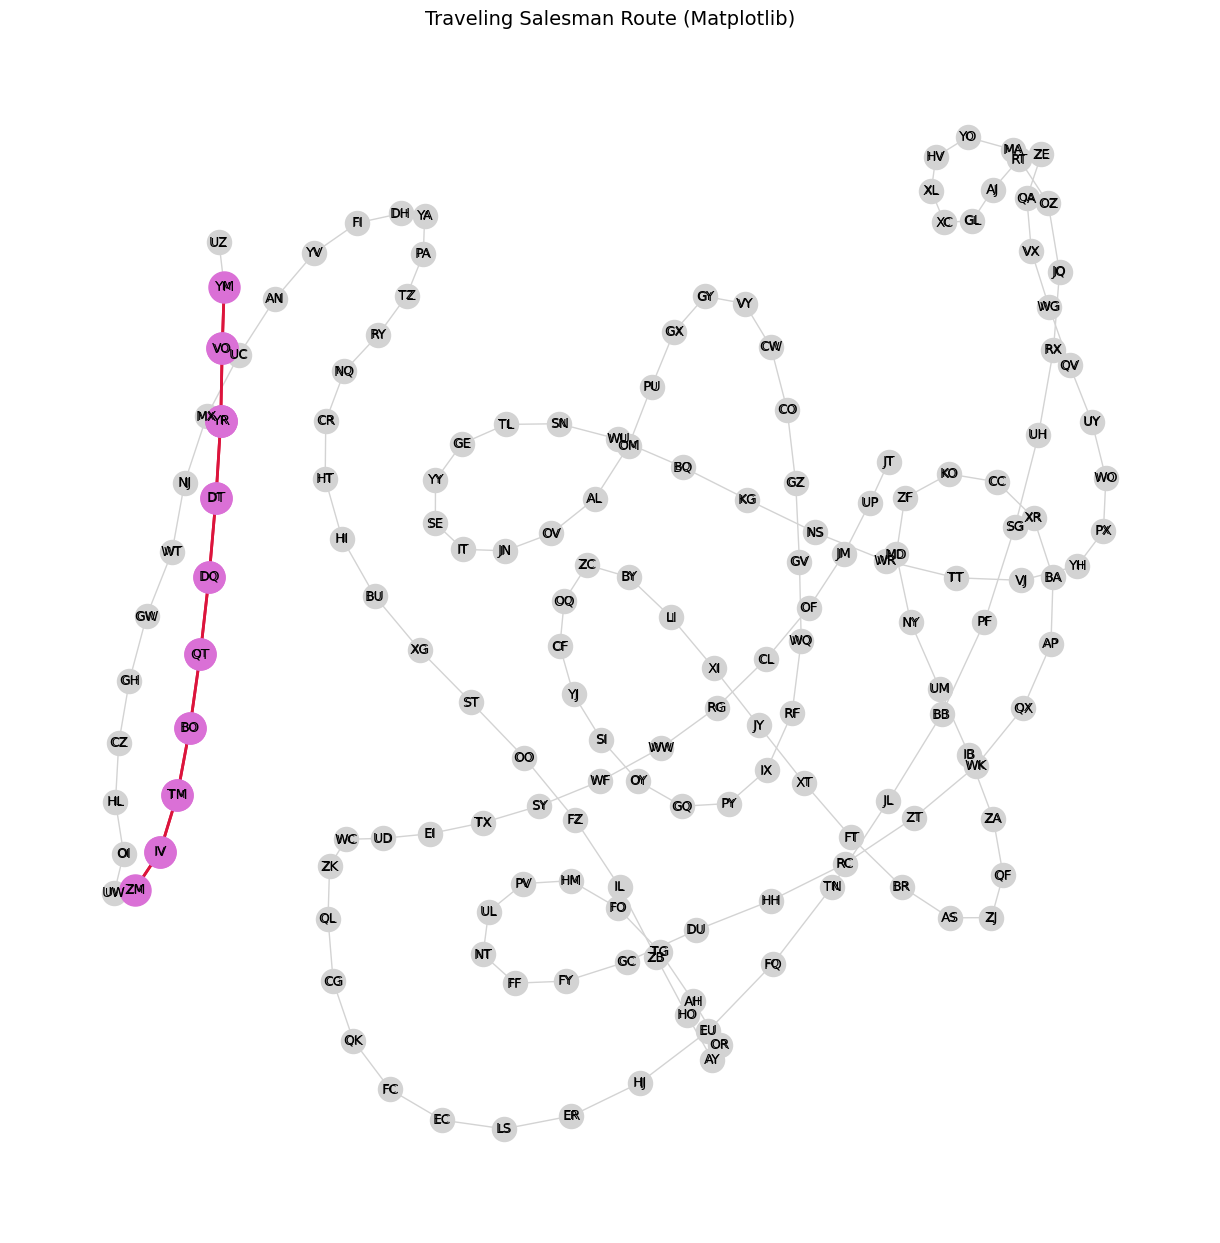

In [75]:
# Define node positions (reusing spring layout for visual clarity)
pos = nx.spring_layout(G_undirected, seed=42)

plt.figure(figsize=(12, 12))
nx.draw(G_undirected, pos, node_color="lightgray", edge_color="lightgray", with_labels=True, node_size=300, font_size=8)

# Highlight TSP path
tsp_edges = list(zip(tsp_path, tsp_path[1:] + [tsp_path[0]]))  # create a cycle
nx.draw_networkx_nodes(G_undirected, pos, nodelist=tsp_path, node_color="orchid", node_size=500)
nx.draw_networkx_edges(G_undirected, pos, edgelist=tsp_edges, edge_color="crimson", width=2)
nx.draw_networkx_labels(G_undirected, pos, font_size=10, font_color="black")

plt.title("Traveling Salesman Route (Matplotlib)", fontsize=14)
plt.axis("off")
plt.show()

In this section, we demonstrated how graph theory can be effectively applied to optimize last-mile delivery logistics. By computing the shortest paths, identifying the most central stops, and solving a variant of the Traveling Salesman Problem, we derived routes that minimize total travel distance while highlighting key transit hubs. Visualizations in both Matplotlib and Plotly provided intuitive representations of the proposed delivery paths. These methods lay the foundation for data-driven, scalable route optimization strategies — supporting faster, smarter, and more cost-efficient delivery operations.

## Conclusions

This project explored the optimization of last-mile deliveries using real-world network structures and advanced data techniques. By combining graph theory, centrality metrics, and heuristic algorithms, we modeled and visualized complex delivery networks in both Neo4j and Python. The integration of shortest path analysis, node centrality, and the Traveling Salesman Problem (TSP) provided a holistic understanding of route efficiency and bottlenecks.

Our findings emphasize the importance of network-based modeling for logistics planning — enabling smarter routing, reduced delivery times, and identification of critical transit hubs. The project also highlights how tools like NetworkX, and Neo4j can collaboratively support robust and interpretable delivery optimization solutions.

This lays a strong foundation for further work in predictive logistics, such as:
- **Incorporating real-time traffic or weather conditions**,
- **Applying clustering for dynamic route zoning**,
- **Integrating cost constraints or vehicle capacities**.

Ultimately, this approach equips businesses with actionable strategies to improve operational efficiency and customer satisfaction in last-mile delivery contexts.